In [49]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

print("\n=== TRAIN INFO ===")
print(train.info())

print("\n=== TRAIN NaN count ===")
print(train.isna().sum())

print("\n=== TEST NaN count ===")
print(test.isna().sum())

#just checking a head
print(test.head())
'''
Before implementing any regressin models, I ought to analyse my data and and clean them from any Nan values
As they only work with full quantitative values
'''
#here test.isna().sum() return nan values, so in order to help the model, we're gonna replace
# nan values with the mean

train['Age'] = train['Age'].fillna(train['Age'].median())
#same test
test['Age'] = test['Age'].fillna(test['Age'].median())

test['Fare'] = test['Fare'].fillna(test['Fare'].median())
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

#run another test
print("\n",train.isna().sum())
print("\n",train['Cabin'])
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
test['Embarked'] = test['Embarked'].fillna(test['Embarked'].mode()[0])

train.describe()
train = train.drop(['Name', 'Ticket', 'Cabin'], axis=1)
test  = test.drop(['Name', 'Ticket', 'Cabin'], axis=1)
train.describe()




/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv

=== TRAIN INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

=== TRAIN NaN count ===
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex        

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=train,x='Survived')
plt.title("Surviving's repartition")
plt.show()

#now that we have cleaned our data, before training a model, let us first explore
#and understand our data,

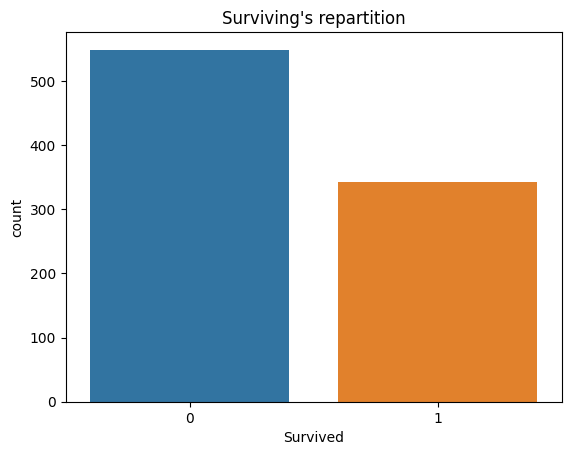

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=train,x='Survived')
plt.title("Surviving's repartition")
plt.show()

As we may see over 500 people perished, and around 350 survived, let us explore further and understand now whether we may detect some correlations

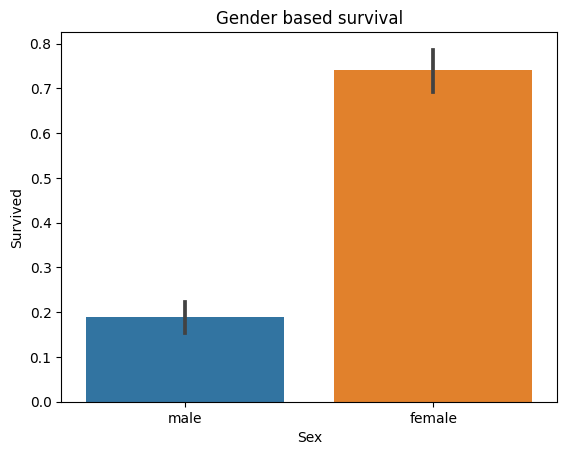

In [51]:
sns.barplot(data=train,x='Sex',y='Survived')
plt.title("Gender based survival")
plt.show()

As seen above, Females tend to be more inclined to survive than males, let us see now in those percentages, those belonging to a higher social class

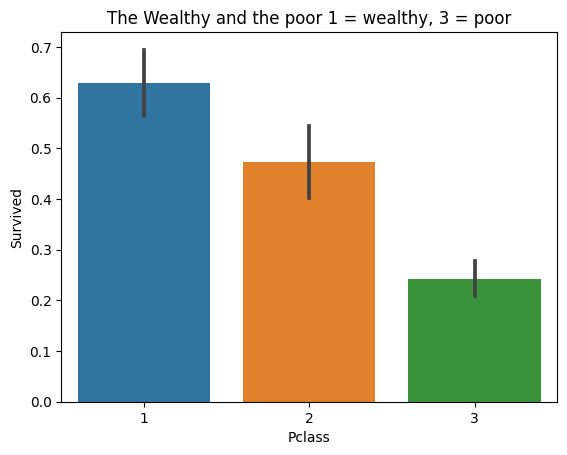

In [52]:
sns.barplot(data=train, x='Pclass', y='Survived')
plt.title("The Wealthy and the poor 1 = wealthy, 3 = poor")
plt.show()


As suspected, The Wealthier you are, the more inclined to survive you are. That raises the question, does wealth upon calamities determine chances of surviving ? Special treatmeants ? 

## 1. Data Preprocessing

We have both quantitative and qualitative features. Since machine learning models require numeric inputs, we encode categorical variables such as **Sex** and **Embarked** using `LabelEncoder`.

---

## 2. Feature and Target Definition

We define our feature matrix \( X \) and target vector \( y \) as follows:

$$
X = \begin{bmatrix}
\text{Pclass} & \text{Sex} & \text{Age} & \text{SibSp} & \text{Parch} & \text{Fare} & \text{Embarked}
\end{bmatrix}
$$

Where each column corresponds to one feature for each passenger.

The target variable \( y \) is:

$$
y = \text{Survived} = 
\begin{cases}
1, & \text{if passenger survived} \\
0, & \text{otherwise}
\end{cases}
$$

---

## 3. Splitting the Dataset

We split the dataset into training and validation sets with an 80/20 ratio, while preserving the distribution of the target variable \( y \) (stratified split).

This means:

$$
(X, y) \xrightarrow{\text{train\_test\_split}} (X_{\text{train}}, y_{\text{train}}, X_{\text{valid}}, y_{\text{valid}})
$$

with

$$
\text{size}(X_{\text{train}}) = 0.8 \times \text{size}(X)
$$

$$
\text{size}(X_{\text{valid}}) = 0.2 \times \text{size}(X)
$$

---

## 4. Logistic Regression Model

Logistic Regression models the probability \( p \) of the positive class (survival) as:

$$
p = P(y=1|X) = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

where

$$
z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n = \beta^T X
$$

Here, \( \sigma(z) \) is the sigmoid function, transforming the linear combination of inputs into a probability between 0 and 1.

The model is trained by maximizing the **log-likelihood**, or equivalently minimizing the **logistic loss function**:

$$
\mathcal{L}(\beta) = -\sum_{i=1}^{m} \left[ y^{(i)} \log p^{(i)} + (1 - y^{(i)}) \log(1 - p^{(i)}) \right]
$$

where \( m \) is the number of training samples.

---

## 5. Model Training and Prediction

We train the model on the training set \( (X_{\text{train}}, y_{\text{train}}) \) by optimizing \( \beta \).

Once trained, predictions \( \hat{y} \) on validation data \( X_{\text{valid}} \) are:

$$
\hat{y} = 
\begin{cases}
1, & \text{if } p \geq 0.5 \\
0, & \text{otherwise}
\end{cases}
$$

---

## 6. Evaluation Metrics

We evaluate the model with the following metrics:

- **Accuracy**:

$$
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} = \frac{TP + TN}{TP + TN + FP + FN}
$$

- **Precision**:

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

- **Recall**:

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

- **F1 Score** (harmonic mean of precision and recall):

$$
F_1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Where:

- \( TP \): True Positives  
- \( TN \): True Negatives  
- \( FP \): False Positives  
- \( FN \): False Negatives  

---


Let us train our model now

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np


#since a model not only read quantitative data, but also not qualitative ones
#after we filled our lines with median data(non sensible to outlier)
#we must encore our qualitative data as numerics
for col in ['Sex','Embarked']:
    label = LabelEncoder()
    train[col] = label.fit_transform(train[col])
    test[col] = label.transform(test[col])

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = train[features]
X_test = test[features]
y = train['Survived']

#Here I encode categorial data and create a new transformer per variable


#Here I split my data and prepare my regression model
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
#here I call upon my LG and set the iterations
model = LogisticRegression(max_iter=300)
#Here I train it with 80% data 80% of labems
model.fit(X_train,y_train)
#Now I use it on real data 20% left
y_pred = model.predict(X_valid)

#Now comes the moment to measure
#amongst all the predictions which are true
accuracy = accuracy_score(y_valid,y_pred)
#amongst all those who survived, who really did ?

precision = precision_score(y_valid, y_pred)
#amongst all who survived
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
errors = 1 - accuracy

print(f"Accuracy : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall : {recall:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"Taux d'erreur : {errors:.3f}")

#now that we have trained our model on the valid(20%) par let's do it again on the whole set wigth X_test
model.fit(X,y)

y_predict = model.predict(X_test)


submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": y_predict
})
print(submission.head(10))


submission.to_csv("submission.csv",index=False)
print("WORK DONE")



Accuracy : 0.804
Precision : 0.793
Recall : 0.667
F1-score : 0.724
Taux d'erreur : 0.196
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0
WORK DONE
